# Introduction to `deepcure` package
We are going first to simulate and then fit a Promotion Time Cure model (PTM henceforth) in its standard form, specifically
$$S_p(t|\mathbf{x}) = \exp(-\theta(\mathbf{x})F(t))$$
where $\theta(\mathbf{x})=\exp(\eta(\mathbf{x})) = \exp(\mathbf{x}^\intercal\mathbf{\beta})$.

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from deepcure.simulations import simDF_PTM
from deepcure.models import DeepPTM

## Simulate data
We simulate 1000 data points from a PTM model with the following parameters:

- $\theta(\mathbf{x})=\exp(1.2x_1-0.5x_2-1.2x_3)$
- $F(t)=1-\exp(-t)$ (exponential distribution with rate 1)

To do so, we use the `simDF_PTM` function as follows:

In [3]:
n_inds = 1000
end_study = 3
df_sim = simDF_PTM(scenario=0, n=n_inds, end_of_study=end_study) # scenario 0 considers a linear predictor

Number of subjects: 1000
Number of events: 481
Event rate (#events/n): 0.481


Let's see how the events distribute among the time events:

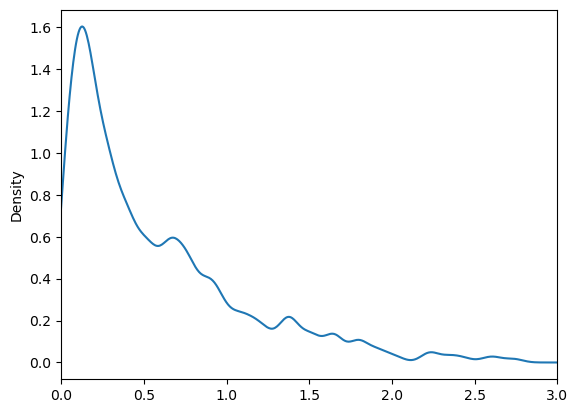

In [4]:
# Kernel density plot of label_event=1 in time
df_sim.loc[df_sim['label_event']==1, 'time_event'].plot.kde(bw_method=0.1, xlim=(0, 3));

## Preprocess data
The steps are simple. If we want to model $F$ as piecewise exponential, we need to define the breakpoints. Also, we need to transform the data into TensorFlow format.

In [5]:
# create break_val equal to the quantiles of time_event when label_event is 1
break_val = df_sim["time_event"][df_sim["label_event"]==1].values
break_val  = np.quantile(break_val,[0, 0.2, 0.4, 0.6, 0.8, 1])
break_val[0] = 0
break_val[-1] = df_sim["time_event"].max()
break_val = tf.convert_to_tensor(break_val, dtype=tf.float64)

# Data to tf.Tensor
# get the number of columns in the df_sim dataframe that starts with 'x'
num_covs = len(df_sim.columns[df_sim.columns.str.startswith('x')])
x_data = tf.convert_to_tensor(df_sim.iloc[:, 0:num_covs].values.reshape(-1, num_covs), dtype=tf.float64)
label_data = tf.convert_to_tensor(df_sim["label_event"], dtype=tf.float64)
time_data = tf.convert_to_tensor(df_sim["time_event"], dtype=tf.float64)

df_sim_tensor = {'x':x_data,
        'label_event':label_data,
        'time_event':time_data}

We can now split the data into training and test sets. We simple use the first 80% of the data for training and the rest for testing.

In [6]:
# split df_sim_tensor data into train and validation sets
train_data = {'x':df_sim_tensor['x'][:int(0.8*n_inds)],
        'label_event':df_sim_tensor['label_event'][:int(0.8*n_inds)],
        'time_event':df_sim_tensor['time_event'][:int(0.8*n_inds)]}
valid_data = {'x':df_sim_tensor['x'][int(0.8*n_inds):],
        'label_event':df_sim_tensor['label_event'][int(0.8*n_inds):],
        'time_event':df_sim_tensor['time_event'][int(0.8*n_inds):]}

## Define the model
We fit two models that differ in the definition of the $F$ function. The first model uses the piecewise exponential function, while the second model assumes a Weibull function.

Let's define and train the model with the piecewise exponential function:

In [9]:
# create DeepPTM model with Piecewise Exponential F
n_epochs = 500
b_size = 64
stack_eta_PE = [tf.keras.layers.Dense(1, activation='linear', dtype=tf.float64, name = "eta", use_bias=False)] # stack of layers for the predictor
model_PE = DeepPTM(stack_eta = stack_eta_PE, t_func='pe', break_val=break_val) # define the model
# compile the model
lr_pe = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01, decay_steps=100, decay_rate=0.5)
model_PE.compile(tf.keras.optimizers.RMSprop(learning_rate=lr_pe))
# define the callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Fit the model
model_PE.fit(train_data, epochs=n_epochs, batch_size=b_size, validation_data=valid_data, callbacks=[early_stopping], verbose=0)

Now, let's define and train the model with the Weibull function:

In [10]:
# create DeepPTM model with F as a Weibull distribution
stack_eta_W = [tf.keras.layers.Dense(1, activation='linear', dtype=tf.float64, name = "eta")] # same stack of layers for the predictor
model_W = DeepPTM(stack_eta = stack_eta_W, t_func='weibull') # define the model
# compile the model
lr_w = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01, decay_steps=100, decay_rate=0.5) 
model_W.compile(tf.keras.optimizers.RMSprop(learning_rate=lr_w))
# define the callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Fit the model
model_W.fit(train_data, epochs=n_epochs, batch_size=b_size, validation_data=valid_data, callbacks=[early_stopping], verbose=0)

## Results
Let's first check the parameter estimates for the models. To get the coefficients of the model predictor, we extract the `eta` layer coefficients (last layer in the defined stack of layers). 

In [11]:
# Coefficients associated with the linear predictor
print("True coefficients:",[1.2, -0.5, -1.2])
print("PE model:", [round(x,2) for x in model_PE.get_layer('eta').get_weights()[0].ravel()] )
print("W model:", [round(x,2) for x in model_W.get_layer('eta').get_weights()[0].ravel()])

True coefficients: [1.2, -0.5, -1.2]
PE model: [1.14, -0.45, -1.17]
W model: [1.06, -0.29, -1.09]


Moreover, to get the coefficients of the $F$ parametrization, we extract the `endpoint` layer coefficients.

In [12]:
# Coefficients of the PE and Weibull functions (since the simulated data follow an Exponential distribution with rate 1, we expect the coefficients to be close to 1)
print(model_PE.get_layer('endpoint').get_weights()[0])
print(model_W.get_layer('endpoint').get_weights()[0])

[0.97594994 1.0700332  1.0126692  1.1276857  0.988237  ]
[1.0630993  0.87549615]


The estimated predictor ($\eta$) is obtained with the `eta_predict` function as follows:

In [13]:
eta_est_PE = model_PE.eta_predict(valid_data)
eta_est_W = model_W.eta_predict(valid_data)

Let's plot the estimated $\eta$ with respect to the true predictor.

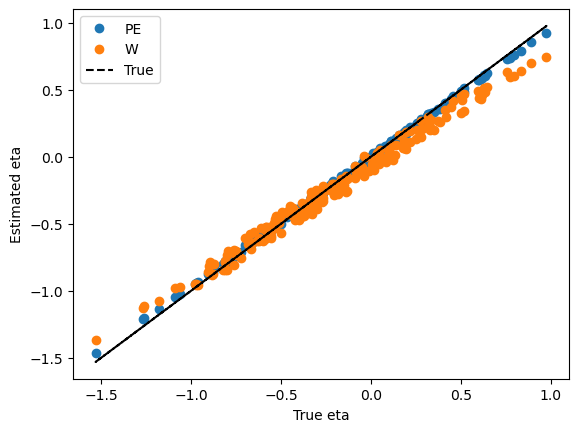

In [14]:
# plot both eta_est_PE, eta_est_W versus df_sim['eta']
plt.plot(df_sim['eta'][int(0.8*n_inds):], eta_est_PE, 'o', label='PE')
plt.plot(df_sim['eta'][int(0.8*n_inds):], eta_est_W, 'o', label='W')
plt.plot(df_sim['eta'][int(0.8*n_inds):], df_sim['eta'][int(0.8*n_inds):], 'k--', label='True')
plt.xlabel('True eta')
plt.ylabel('Estimated eta')
plt.legend()
plt.show()

If we want to get the $S(t)=1-F(t)$ estimates, we can use the `surv_predict` function as follows:

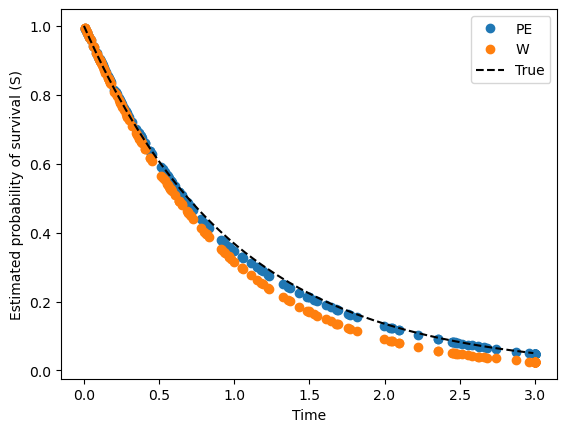

In [15]:
S_PE = model_PE.surv_predict(valid_data)
S_W = model_W.surv_predict(valid_data)
plt.plot(df_sim['time_event'][int(0.8*n_inds):], S_PE, 'o', label='PE')
plt.plot(df_sim['time_event'][int(0.8*n_inds):], S_W, 'o', label='W')
plt.plot(np.arange(0,3,0.01), np.exp(-np.arange(0,3,0.01)), 'k--', label='True')
plt.xlabel('Time')
plt.ylabel('Estimated probability of survival (S)')
plt.legend()
plt.show()


Moreover, if we want to get the $S_p(t)$ estimates, we can use the `surv_predict` function specifying `type='Sp'` as follows:

In [16]:
Sp_PE = model_PE.surv_predict(valid_data, type='Sp')
Sp_W = model_W.surv_predict(valid_data, type='Sp')

Analogously, if we want to get the estimates of the hazard functions, we can use the `haz_predict` function as follows

In [17]:
h_PE = model_PE.haz_predict(valid_data)
h_W = model_W.haz_predict(valid_data)

## Performance metrics
We can use the `performance` function to get the performance metrics for the models. The performance metrics are:
- `auc_c`: Area under the ROC curve for the long term survival function
- `ibs`: Integrated Brier score

In [20]:
# AUC (area under the curve) for the long term survival curve
model_PE.performance(valid_data, metric='auc_c')

0.6797816665719969

In [19]:
# Integrated Brier score
time_eval = np.linspace(0, np.max(df_sim["time_event"]),100)
model_PE.performance(valid_data, metric='ibs',time_eval=time_eval, inputs_train=train_data)

0.6425677549647237